# RGB Composites/Vegetation indexes

I want to avoid having to know:
- `b04` maps to red
- `b03` maps to green
...

in:

```python
red = dt["measurements/reflectance/r10m"]["b04"].chunk({"x": 512, "y": 512})
green = dt["measurements/reflectance/r10m"]["b03"].chunk({"x": 512, "y": 512})
blue = dt["measurements/reflectance/r10m"]["b02"].chunk({"x": 512, "y": 512})
nir = dt["measurements/reflectance/r10m"]["b08"].chunk({"x": 512, "y": 512})
```

**As a user of the EOPF data, I want to access the bands using the STAC `command-band-name`**


In [1]:
import xarray as xr
import cf_xarray as cfxr
import pystac
import matplotlib.pyplot as plt

In [2]:
item_url = "https://stac.core.eopf.eodc.eu/collections/sentinel-2-l2a/items/S2B_MSIL2A_20210713T184919_N0500_R113_T10TFK_20230309T061122"

In [3]:
item = pystac.read_file(item_url)

dt = xr.open_datatree(
    item.assets["product"].href, engine="zarr", chunks={}, decode_timedelta=True
)

In [4]:
type(dt["measurements/reflectance/r10m"])

xarray.core.datatree.DataTree

In [5]:
dt["measurements/reflectance/r10m"]

<xarray.DataTree 'r10m'>
Group: /measurements/reflectance/r10m
    Dimensions:  (y: 10980, x: 10980)
    Coordinates:
      * x        (x) int64 88kB 600005 600015 600025 600035 ... 709775 709785 709795
      * y        (y) int64 88kB 4499995 4499985 4499975 ... 4390225 4390215 4390205
    Data variables:
        b02      (y, x) float64 964MB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
        b03      (y, x) float64 964MB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
        b04      (y, x) float64 964MB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
        b08      (y, x) float64 964MB dask.array<chunksize=(1830, 1830), meta=np.ndarray>

Add a `"standard_name"` to the attributes. In practice it should be `common-band-name`:

In [6]:
dt["measurements/reflectance/r10m"]["b04"].attrs["standard_name"] = "red"
dt["measurements/reflectance/r10m"]["b03"].attrs["standard_name"] = "green"
dt["measurements/reflectance/r10m"]["b02"].attrs["standard_name"] = "blue"
dt["measurements/reflectance/r10m"]["b08"].attrs["standard_name"] = "nir"


dt["measurements/reflectance/r10m"]["b04"].attrs

{'_eopf_attrs': {'add_offset': -0.1,
  'coordinates': ['x', 'y'],
  'dimensions': ['y', 'x'],
  'dtype': '<u2',
  'fill_value': 0,
  'long_name': 'BOA reflectance from MSI acquisition at spectral band b04 665.0 nm',
  'scale_factor': 0.0001,
  'units': 'digital_counts'},
 'dtype': '<u2',
 'fill_value': 0,
 'long_name': 'BOA reflectance from MSI acquisition at spectral band b04 665.0 nm',
 'proj:bbox': [600000.0, 4390200.0, 709800.0, 4500000.0],
 'proj:epsg': 32610,
 'proj:shape': [10980, 10980],
 'proj:transform': [10.0, 0.0, 600000.0, 0.0, -10.0, 4500000.0, 0.0, 0.0, 1.0],
 'proj:wkt2': 'PROJCS["WGS 84 / UTM zone 10N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-123],PARAMETER["sc

In [7]:
ds = dt["measurements/reflectance/r10m"].to_dataset()

Use [cf-xarray](https://cf-xarray.readthedocs.io/) with a custom band criteria:

In [8]:
band_criteria = {
    "b04": {"standard_name": "red"},
    "b03": {"standard_name": "green"},
    "b02": {"standard_name": "blue"},
    "b08": {"standard_name": "nir"},
}

with cfxr.set_options(custom_criteria=band_criteria):
    red = ds.cf["b04"]
    green = ds.cf["b03"]
    blue = ds.cf["b02"]
    nir = ds.cf["b08"]

Now `ds` has "cf keys":

In [9]:
ds.cf.keys()

{'blue', 'green', 'nir', 'red'}

Access the `green` band:

In [10]:
ds.cf["green"]

<xarray.DataArray 'b03' (y: 10980, x: 10980)> Size: 964MB
dask.array<open_dataset-b03, shape=(10980, 10980), dtype=float64, chunksize=(1830, 1830), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) int64 88kB 600005 600015 600025 600035 ... 709775 709785 709795
  * y        (y) int64 88kB 4499995 4499985 4499975 ... 4390225 4390215 4390205
Attributes: (12/13)
    _eopf_attrs:     {'add_offset': -0.1, 'coordinates': ['x', 'y'], 'dimensi...
    dtype:           <u2
    fill_value:      0
    long_name:       BOA reflectance from MSI acquisition at spectral band b0...
    proj:bbox:       [600000.0, 4390200.0, 709800.0, 4500000.0]
    proj:epsg:       32610
    ...              ...
    proj:transform:  [10.0, 0.0, 600000.0, 0.0, -10.0, 4500000.0, 0.0, 0.0, 1.0]
    proj:wkt2:       PROJCS["WGS 84 / UTM zone 10N",GEOGCS["WGS 84",DATUM["WG...
    units:           digital_counts
    valid_max:       65535
    valid_min:       1
    standard_name:   green

Plot RGB composites

In [11]:
concat = xr.concat(
    [
        ds.cf["red"].isel(x=slice(None, None, 10), y=slice(None, None, 10)),
        ds.cf["green"].isel(x=slice(None, None, 10), y=slice(None, None, 10)),
        ds.cf["blue"].isel(x=slice(None, None, 10), y=slice(None, None, 10)),
    ],
    dim="band",
)

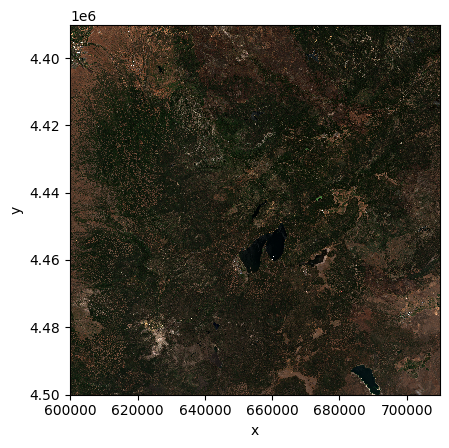

/workspace/.venv-eopf/lib/python3.12/site-packages/dask/_task_spec.py:758: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)
/workspace/.venv-eopf/lib/python3.12/site-packages/dask/_task_spec.py:758: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/workspace/.venv-eopf/lib/python3.12/site-packages/dask/_task_spec.py:758: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


In [ ]:
concat = (concat / 0.4).clip(0, 1)

ax = concat.plot.imshow()
ax.axes.set_aspect("equal")
plt.gca().invert_yaxis()

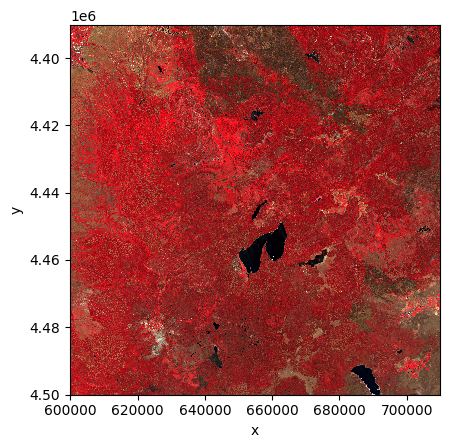

In [13]:
concat = xr.concat(
    [
        ds.cf["nir"].isel(x=slice(None, None, 10), y=slice(None, None, 10)),
        ds.cf["red"].isel(x=slice(None, None, 10), y=slice(None, None, 10)),
        ds.cf["green"].isel(x=slice(None, None, 10), y=slice(None, None, 10)),
    ],
    dim="band",
)

concat = (concat / 0.4).clip(0, 1)

ax = concat.plot.imshow()
ax.axes.set_aspect("equal")
plt.gca().invert_yaxis()

Plot vegetation indexes

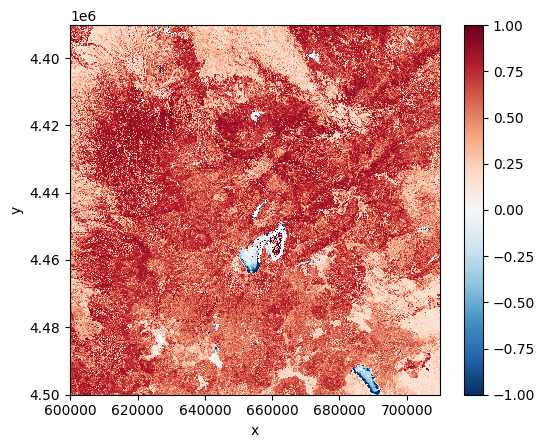

In [15]:
ndvi = (
    ds.cf["nir"].isel(x=slice(None, None, 10), y=slice(None, None, 10)).clip(0, 1)
    - ds.cf["red"].isel(x=slice(None, None, 10), y=slice(None, None, 10)).clip(0, 1)
) / (
    ds.cf["nir"].isel(x=slice(None, None, 10), y=slice(None, None, 10)).clip(0, 1)
    + ds.cf["red"].isel(x=slice(None, None, 10), y=slice(None, None, 10)).clip(0, 1)
)
ax = ndvi.plot.imshow()
ax.axes.set_aspect("equal")
plt.gca().invert_yaxis()

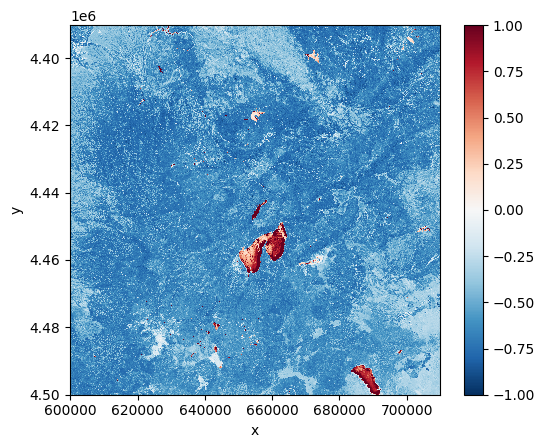

In [16]:
ndwi = (
    ds.cf["green"].isel(x=slice(None, None, 10), y=slice(None, None, 10)).clip(0, 1)
    - ds.cf["nir"].isel(x=slice(None, None, 10), y=slice(None, None, 10)).clip(0, 1)
) / (
    ds.cf["green"].isel(x=slice(None, None, 10), y=slice(None, None, 10)).clip(0, 1)
    + ds.cf["nir"].isel(x=slice(None, None, 10), y=slice(None, None, 10)).clip(0, 1)
)
ax = ndwi.plot.imshow()
ax.axes.set_aspect("equal")
plt.gca().invert_yaxis()